In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Rice Leaf Disease


In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
initial_lr = .001
batch_size = 8
default_image_size = tuple((128, 128))
image_size = 0
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
directory_root = 'dataset'
image_list, label_list = [], []
try:
    print("Loading images ...")
    root_dir = listdir(directory_root)
    for disease_folder in root_dir:
        image_pth = listdir(f"{directory_root}/{disease_folder}")
            
        for image_file in image_pth:
            image_dir = f"{directory_root}/{disease_folder}/{image_file}"
            if ".jpg" in image_file or ".JPG" in image_file or ".png" in image_file or ".PNG" in image_file:
                image_list.append(convert_image_to_array(image_dir))
                label_list.append(disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

Loading images ...
[INFO] Image loading completed


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [ ]:
print("Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.25, random_state = 42) 

Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, \
     Add, Dense, BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D

def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def entry_flow(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3)
    tensor = ReLU()(x)

    x = sep_bn(tensor, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=128, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=256, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=728, kernel_size=1, strides=2)
    x = Add()([tensor, x])

    return x


def middle_flow(tensor):
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)

        tensor = Add()([tensor, x])

    return tensor


def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=1024, kernel_size=3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=1024, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = sep_bn(x, filters=1536, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=2048, kernel_size=3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(units=4, activation='softmax')(x)

    return x


input = Input(shape=[128, 128, 3])

x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)
model = Model(input, output)

In [ ]:
import tensorflow as tf  
#stop training is model accuracy reached 99% 
class myCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('val_acc')>0.96): 
      self.model.stop_training = True

In [ ]:
import tensorflow as tf  
checkpoint_filepath='/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
epochs = 30
opt = Adam(learning_rate=initial_lr, decay=initial_lr / epochs)
# distribution
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["acc"])
callbacks = myCallback() 

In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs, verbose=1,
    callbacks=[model_checkpoint_callback]
    )

Epoch 1/30
556/556 [==============================] - ETA: 0s - loss: 0.9267 - acc: 0.6584

556/556 [==============================] - 44s 72ms/step - loss: 0.9267 - acc: 0.6584 - val_loss: 1.0691 - val_acc: 0.5677
Epoch 2/30
556/556 [==============================] - ETA: 0s - loss: 0.6478 - acc: 0.7504

556/556 [==============================] - 39s 69ms/step - loss: 0.6478 - acc: 0.7504 - val_loss: 1.2134 - val_acc: 0.6606
Epoch 3/30
556/556 [==============================] - ETA: 0s - loss: 0.5092 - acc: 0.8037

556/556 [==============================] - 39s 69ms/step - loss: 0.5092 - acc: 0.8037 - val_loss: 0.6914 - val_acc: 0.7589
Epoch 4/30
556/556 [==============================] - ETA: 0s - loss: 0.4135 - acc: 0.8502

556/556 [==============================] - 41s 73ms/step - loss: 0.4135 - acc: 0.8502 - val_loss: 0.2742 - val_acc: 0.8970
Epoch 5/30
556/556 [==============================] - ETA: 0s - loss: 0.3463 - acc: 0.8774

556/556 [==============================] - 38s 69ms/step - loss: 0.3463 - acc: 0.8774 - val_loss: 0.2003 - val_acc: 0.9374
Epoch 6/30
556/556 [==============================] - ETA: 0s - loss: 0.2866 - acc: 0.9033

556/556 [==============================] - 39s 69ms/step - loss: 0.2866 - acc: 0.9033 - val_loss: 0.3061 - val_acc: 0.8559
Epoch 7/30
556/556 [==============================] - ETA: 0s - loss: 0.2419 - acc: 0.9128

556/556 [==============================] - 40s 71ms/step - loss: 0.2419 - acc: 0.9128 - val_loss: 0.1754 - val_acc: 0.9320
Epoch 8/30
556/556 [==============================] - ETA: 0s - loss: 0.1980 - acc: 0.9305

556/556 [==============================] - 39s 70ms/step - loss: 0.1980 - acc: 0.9305 - val_loss: 0.1147 - val_acc: 0.9535
Epoch 9/30
556/556 [==============================] - ETA: 0s - loss: 0.1680 - acc: 0.9422

556/556 [==============================] - 41s 74ms/step - loss: 0.1680 - acc: 0.9422 - val_loss: 0.1080 - val_acc: 0.9697
Epoch 10/30
556/556 [==============================] - ETA: 0s - loss: 0.1639 - acc: 0.9456

556/556 [==============================] - 39s 71ms/step - loss: 0.1639 - acc: 0.9456 - val_loss: 0.0863 - val_acc: 0.9710
Epoch 11/30
556/556 [==============================] - ETA: 0s - loss: 0.1249 - acc: 0.9557

556/556 [==============================] - 39s 70ms/step - loss: 0.1249 - acc: 0.9557 - val_loss: 0.1180 - val_acc: 0.9643
Epoch 12/30
556/556 [==============================] - ETA: 0s - loss: 0.1084 - acc: 0.9631

556/556 [==============================] - 39s 70ms/step - loss: 0.1084 - acc: 0.9631 - val_loss: 0.0238 - val_acc: 0.9906
Epoch 13/30
556/556 [==============================] - ETA: 0s - loss: 0.1051 - acc: 0.9656

556/556 [==============================] - 39s 70ms/step - loss: 0.1051 - acc: 0.9656 - val_loss: 0.0236 - val_acc: 0.9906
Epoch 14/30
556/556 [==============================] - ETA: 0s - loss: 0.0980 - acc: 0.9672

556/556 [==============================] - 41s 74ms/step - loss: 0.0980 - acc: 0.9672 - val_loss: 0.0146 - val_acc: 0.9973
Epoch 15/30
556/556 [==============================] - ETA: 0s - loss: 0.0875 - acc: 0.9728

556/556 [==============================] - 39s 71ms/step - loss: 0.0875 - acc: 0.9728 - val_loss: 0.0192 - val_acc: 0.9973
Epoch 16/30
556/556 [==============================] - ETA: 0s - loss: 0.0815 - acc: 0.9730

556/556 [==============================] - 40s 71ms/step - loss: 0.0815 - acc: 0.9730 - val_loss: 0.0221 - val_acc: 0.9926
Epoch 17/30
556/556 [==============================] - ETA: 0s - loss: 0.0697 - acc: 0.9782

556/556 [==============================] - 39s 70ms/step - loss: 0.0697 - acc: 0.9782 - val_loss: 0.0405 - val_acc: 0.9879
Epoch 18/30
556/556 [==============================] - ETA: 0s - loss: 0.0573 - acc: 0.9820

556/556 [==============================] - 41s 73ms/step - loss: 0.0573 - acc: 0.9820 - val_loss: 0.0047 - val_acc: 0.9993
Epoch 19/30
556/556 [==============================] - ETA: 0s - loss: 0.0599 - acc: 0.9784

556/556 [==============================] - 39s 70ms/step - loss: 0.0599 - acc: 0.9784 - val_loss: 0.0190 - val_acc: 0.9926
Epoch 20/30
556/556 [==============================] - ETA: 0s - loss: 0.0556 - acc: 0.9820

556/556 [==============================] - 40s 71ms/step - loss: 0.0556 - acc: 0.9820 - val_loss: 0.1907 - val_acc: 0.9401
Epoch 21/30
556/556 [==============================] - ETA: 0s - loss: 0.0578 - acc: 0.9825

556/556 [==============================] - 39s 70ms/step - loss: 0.0578 - acc: 0.9825 - val_loss: 0.0141 - val_acc: 0.9953
Epoch 22/30
556/556 [==============================] - ETA: 0s - loss: 0.0597 - acc: 0.9811

556/556 [==============================] - 41s 74ms/step - loss: 0.0597 - acc: 0.9811 - val_loss: 0.0365 - val_acc: 0.9919
Epoch 23/30
556/556 [==============================] - ETA: 0s - loss: 0.0434 - acc: 0.9836

556/556 [==============================] - 39s 71ms/step - loss: 0.0434 - acc: 0.9836 - val_loss: 0.1062 - val_acc: 0.9751
Epoch 24/30
556/556 [==============================] - ETA: 0s - loss: 0.0540 - acc: 0.9822

556/556 [==============================] - 39s 70ms/step - loss: 0.0540 - acc: 0.9822 - val_loss: 0.0041 - val_acc: 0.9993
Epoch 25/30
556/556 [==============================] - ETA: 0s - loss: 0.0412 - acc: 0.9867

556/556 [==============================] - 40s 72ms/step - loss: 0.0412 - acc: 0.9867 - val_loss: 0.0408 - val_acc: 0.9859
Epoch 26/30
556/556 [==============================] - ETA: 0s - loss: 0.0551 - acc: 0.9843

556/556 [==============================] - 41s 73ms/step - loss: 0.0551 - acc: 0.9843 - val_loss: 0.0256 - val_acc: 0.9933
Epoch 27/30
556/556 [==============================] - ETA: 0s - loss: 0.0392 - acc: 0.9883

556/556 [==============================] - 39s 70ms/step - loss: 0.0392 - acc: 0.9883 - val_loss: 0.0095 - val_acc: 0.9987
Epoch 28/30
556/556 [==============================] - ETA: 0s - loss: 0.0316 - acc: 0.9897

556/556 [==============================] - 39s 70ms/step - loss: 0.0316 - acc: 0.9897 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 29/30
556/556 [==============================] - ETA: 0s - loss: 0.0453 - acc: 0.9865

556/556 [==============================] - 39s 70ms/step - loss: 0.0453 - acc: 0.9865 - val_loss: 0.0190 - val_acc: 0.9919
Epoch 30/30
556/556 [==============================] - ETA: 0s - loss: 0.0243 - acc: 0.9910

556/556 [==============================] - 39s 69ms/step - loss: 0.0243 - acc: 0.9910 - val_loss: 0.0034 - val_acc: 0.9987


In [ ]:
model.save('model.h5')

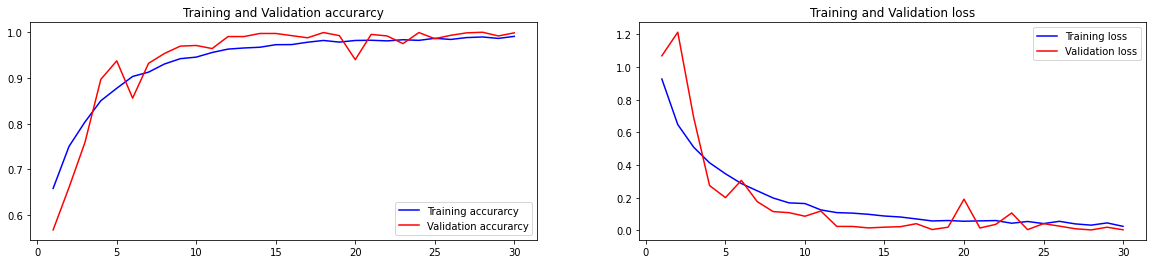

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.subplot(1,2,2)
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
print("[INFO] Calculating model accuracy")
model = tf.keras.models.load_model('exception2.h5')
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
47/47 [==============================] - 3s 47ms/step - loss: 0.0032 - acc: 0.9993
Test Accuracy: 99.93265867233276


In [ ]:
print(label_binarizer.classes_)

['Bacterialblight' 'Blast' 'Brownspot' 'Tungro']


In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

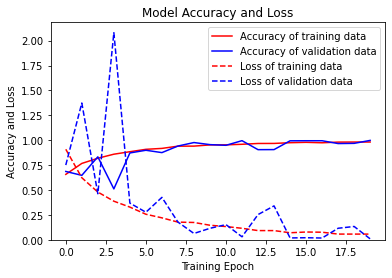

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
